# Описание задачи

В этом задании необходимо достичь максимального качества предсказания, используя навыки полученные за 4 недели обучения

Кто достигнет максимального значения на тестовой выборке, получит *15 баллов*

Пожалуйста, оформляйте ноутбук аккуратно. Все выводы подписывайте, оформляйте заголовки.

Для справедливой оценки все должны использовать одну и ту же часть исходного датасета в качестве тестового набора данных. Используйте разбиение приведенное ниже


```
train_test_split(X, y, test_size = 0.3, random_state = 69)
```
И модель, с которой вы работаете - это линейная регрессия. Другие алгоритмы не используйте.

Метрика, которую вы должны максимизировать

```
r2_score(y_test, y_pred) и root_mean_squared_error(y_test, y_pred)
```

Целевая переменная - *count*

Обратите внимание на столбцы - 'casual', 'registered'. Эти столбцы в сумме дают целевую переменную, по этой причине их надо удалить. Они линейно зависимы.




Используйтие средства библиотеки sklearn, внимательно изучите ее. Существует огромное количество методов для выполнения каждого из этапов, не бойтесь использовать методы неприведенные в лекции

Этапы, которые необходимо проделать в работе для успешного достижения результата:
* EDA (Исследовать данные, понять с чем имеете дело, наработать идеи для генерации фичей и их обработки, обязательно корреляционные матрицы и графики с hue=классы объектов)
* Анализ выбросов и их обработка (в задачах классификации выброс - это объект с таким признаковым описанием, которое отличается очень сильно от типичного и больше соответствует другому классу)
* Генерация новых фичей
* Обработка пропусков (вы можете сгенерировать новые фичи с пропусками, тогда надо подумать об их обработке)
* Обработка категориальных признаков
* Масштабирование вещественных признаков
* Трансформирование таргета
* Нелинейные автоматические трансформации признаков (Kernel Trick, Transfomers)
* Подбор параметров модели (можете менять не только константы, но и оптимизационные алгоритмы и методы регуляризации)
* Отбор признаков
* Обязательно: Составление пайплайна обучения
* Обязательно: Постройте график зависимости y_pred от y_true в разбиении на test и train. Предсказание идеального алгоритма даст прямую y=x, посмотрите какой график получается у вас.

# Bike Sharing Demand
По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные.

### Библиотеки

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, TargetEncoder, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import uniform
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer

### Загрузка данных

In [46]:
data = pd.read_csv('bike_sharing_demand.csv')
data.drop(['casual', 'registered', 'atemp'], axis=1, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data[data['season'] != 4]

data.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

### EDA

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8152 entries, 0 to 9518
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    8152 non-null   datetime64[ns]
 1   season      8152 non-null   int64         
 2   holiday     8152 non-null   int64         
 3   workingday  8152 non-null   int64         
 4   weather     8152 non-null   int64         
 5   temp        8152 non-null   float64       
 6   humidity    8152 non-null   int64         
 7   windspeed   8152 non-null   float64       
 8   count       8152 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 636.9 KB


In [48]:
data.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1


In [49]:
data.describe()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
count,8152,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000
mean,2011-11-11 16:00:49.460255232,2.005765,0.026374,0.682777,1.404563,21.432056,60.448602,13.175437,189.087586
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,1.000000
25%,2011-05-11 19:45:00,1.000000,0.000000,0.000000,1.000000,14.760000,45.000000,7.001500,40.000000
50%,2012-01-01 20:30:00,2.000000,0.000000,1.000000,1.000000,22.960000,60.000000,12.998000,139.000000
75%,2012-05-11 01:15:00,3.000000,0.000000,1.000000,2.000000,27.880000,77.000000,19.001200,281.000000
max,2012-09-19 23:00:00,3.000000,1.000000,1.000000,4.000000,41.000000,100.000000,56.996900,977.000000
std,NaN,0.815348,0.160254,0.465424,0.630255,8.233210,19.492873,8.236045,182.253656


### Разделение признаков на вещественные и категориальные

In [50]:
num_features = ['temp', 'humidity', 'windspeed']
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'hour', 'day', 'month', 'year', 'weekday', 'is_weekend', 'is_rush_hour', 
                        'is_night', 'is_business_hours', 'season_weather', 'holiday_weekend', 'workingday_hour', 'high_temp', 'high_humidity', 'high_wind']
num_date_features = ['temp', 'humidity', 'windspeed', 'temp_squared', 'humidity_squared', 'windspeed_squared', 'temp_humidity', 'hour', 'day', 
                     'month', 'year', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'weekday_cos', 'weekday_sin']

### Разделение данных на тренировочную и тестовую выборки

In [51]:
X = data.drop(['count'], axis=1)
y = data['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Создание трансформера для признаков даты

In [52]:
class DateTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_column='datetime'):
        self.datetime_column = datetime_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['hour'] = X[self.datetime_column].dt.hour
        X['day'] = X[self.datetime_column].dt.day
        X['month'] = X[self.datetime_column].dt.month
        X['year'] = X[self.datetime_column].dt.year
        X['weekday'] = X[self.datetime_column].dt.weekday
        X['is_weekend'] = (X['weekday'] > 5).astype(int)
        X['temp_squared'] = X['temp'] ** 2
        X['humidity_squared'] = X['humidity'] ** 2
        X['windspeed_squared'] = X['windspeed'] ** 2
        X['temp_humidity'] = X['temp'] * X['humidity']
        X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
        X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
        X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
        X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
        X['day_sin'] = np.sin(2 * np.pi * X['day'] / 31)
        X['day_cos'] = np.cos(2 * np.pi * X['day'] / 31)
        X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
        X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)
        X['is_rush_hour'] = ((X['hour'] >= 6) & (X['hour'] <= 9) | (X['hour'] >= 16) & (X['hour'] <= 19)).astype(int)
        X['is_night'] = ((X['hour'] >= 22) | (X['hour'] <= 5)).astype(int)
        X['is_business_hours'] = ((X['hour'] >= 9) & (X['hour'] < 18)).astype(int)
        X['season_weather'] = X['season'].astype(str) + '_' + X['weather'].astype(str)
        X['holiday_weekend'] = X['holiday'].astype(int) + X['is_weekend'].astype(int)
        X['workingday_hour'] = X['workingday'].astype(str) + '_' + X['hour'].astype(str)
        X['high_temp'] = (X['temp'] > X['temp'].median()).astype(int)
        X['high_humidity'] = (X['humidity'] > X['humidity'].median()).astype(int)
        X['high_wind'] = (X['windspeed'] > X['windspeed'].median()).astype(int)
        X.drop(self.datetime_column, axis=1, inplace=True)
        return X

### Анализ выбросов и их обработка

<Axes: >

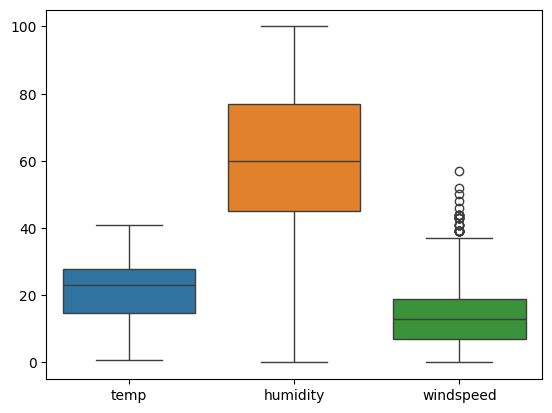

In [53]:
sns.boxplot(data=X_train[['temp', 'humidity', 'windspeed']])

In [54]:
def replace_outliers(data, features):
    for c in features:
        Q1 = np.percentile(data[c], 25)
        Q3 = np.percentile(data[c], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        median = data[c].median()
        data.loc[(data[c] < Q1 - outlier_step) | (data[c] > Q3 + outlier_step), c] = median
    return data

X_train = replace_outliers(X_train, ['temp', 'humidity', 'windspeed'])

<Axes: >

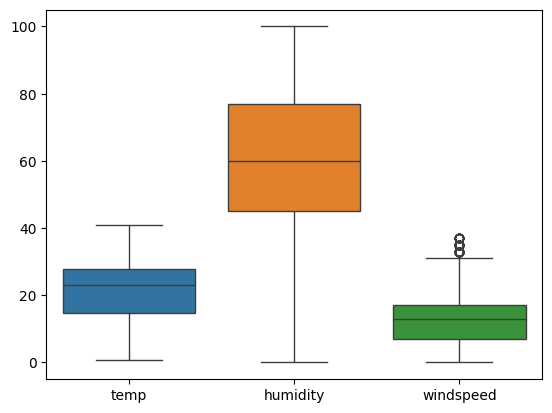

In [55]:
sns.boxplot(data=X_train[['temp', 'humidity', 'windspeed']])

Выбросы были заменены медианой.

### Анализ распределения целевой переменной

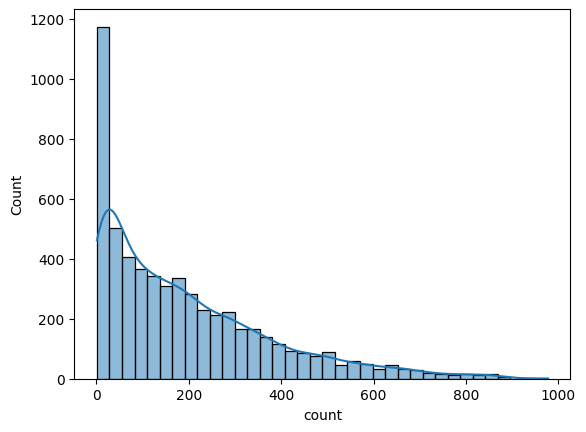

<Axes: ylabel='Count'>

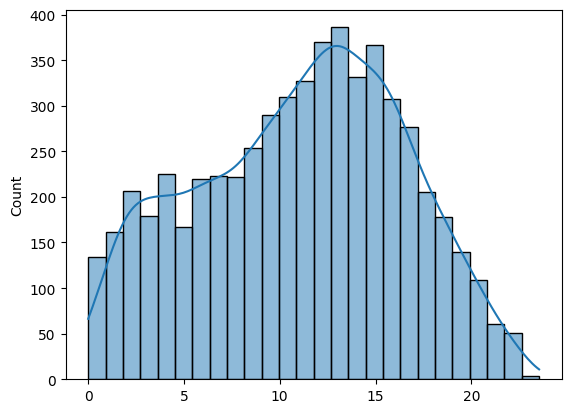

In [56]:
sns.histplot(y_train, kde=True)
plt.show()
y_train_box_cox, _ = stats.boxcox(y_train)
sns.histplot(y_train_box_cox, kde=True)

Благодаря boxcox целевая переменная становится более нормализованной и симметричной.

### Обработка категориальных признаков

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("robust", RobustScaler()),
            ("power", PowerTransformer(method="yeo-johnson"))
        ]), num_date_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ])

### Обучение модели и подбор параметров

In [107]:
param_grid = {
    'alpha': [18],
    'max_iter': [None],
}

model_pipeline = Pipeline(steps=[
    ('datetime_transformer', DateTimeTransformer(datetime_column='datetime')),
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(2)),
    ('regressor', GridSearchCV(Ridge(), cv=5, n_jobs=4, param_grid=param_grid))
])

model = TransformedTargetRegressor(
    regressor=model_pipeline,
    func=np.log1p,
    inverse_func=np.expm1,
)

model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('datetime_transformer',
                                                      DateTimeTransformer()),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('robust',
                                                                                                        RobustScaler()),
                                                                                                       ('power',
                                                                                                        PowerTransformer())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed',
                                                                                        'temp_squared',
                                                                                        'humidity_squared',
                                                                                        'windspee...
                                                                                        'workingday',
                                                                                        'weather',
                                                                                        'hour',
                                                                                        'day',
                                                                                        'month',
                                                                                        'year',
                                                                                        'weekday',
                                                                                        'is_weekend',
                                                                                        'is_rush_hour',
                                                                                        'is_night',
                                                                                        'is_business_hours',
                                                                                        'season_weather',
                                                                                        'holiday_weekend',
                                                                                        'workingday_hour',
                                                                                        'high_temp',
                                                                                        'high_humidity',
                                                                                        'high_wind'])])),
                                                     ('poly',
                                                      PolynomialFeatures()),
                                                     ('regressor',
                                                      GridSearchCV(cv=5,
                                                                   estimator=Ridge(),
                                                                   n_jobs=4,
                                                                   param_grid={'alpha': [18],
                                                                               'max_iter': [None]}))]))

In [109]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)

print(f"r2 (test): {r2_test}\nrmse (test): {rmse_test}\n\nr2 (train): {r2_train}\nrmse (train): {rmse_train}")

r2 (test): 0.9510812706842526
rmse (test): 39.68407441234989

r2 (train): 0.9742960784815404
rmse (train): 29.40207065362784


### Графики

In [112]:
fig_test = go.Figure()
fig_test.add_trace(go.Scatter(x=y_test, y=y_pred_test, mode='markers', name='Test predictions'))
fig_test.add_trace(go.Scatter(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], mode='lines', name='Ideal Test Prediction'))

In [113]:
fig_train = go.Figure()
fig_train.add_trace(go.Scatter(x=y_train, y=y_pred_train, mode='markers', name='Train Predictions'))
fig_train.add_trace(go.Scatter(x=[min(y_train), max(y_train)], y=[min(y_train), max(y_train)], mode='lines', name='Ideal Train Predictions'))